In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_path = "/data/jupiter/datasets/mannequin_in_dust/"
df = pd.read_csv("/mnt/sandbox1/alex.li/summary.csv")
output_path = "/data/jupiter/li.yu/exps/driveable_terrain_model/dust_51_v188_58d_rak_local_fine_tversky11_sum_image_normT_prod5_airdyn_r3a8_s30/mannequin_in_dust_dustpred/"
df_dust = pd.read_csv(output_path + "/output.csv")
df = pd.merge(df, df_dust, on='id')
output_path = "/mnt/sandbox1/alex.li/results/mannequin_in_dust/7class_prod/results"

In [4]:
print(df['pred_dust_ratio'].describe())
print((df['pred_dust_ratio'] > .10).mean())
# print((df_dust[''] > .15).mean())
# print((df_dust['total_thresholded_dust_ratio'] > .05).mean())

count    1441.000000
mean        7.183619
std         9.901956
min         0.000000
25%         0.000000
50%         2.520690
75%        11.835318
max        54.939180
Name: pred_dust_ratio, dtype: float64
0.6439972241498959


In [5]:
df.columns

Index(['Unnamed: 0', 'id', 'camera_location_x', 'operation_time_x',
       'num_classes', 'iq_status', 'dust_percent', 'error', 'predicted_stop',
       'label_stop', 'predicted_human', 'label_human', 'predicted_vehicle',
       'label_vehicle', 'stop_nostop_metrics', 'are_stop_objects_filtered',
       'stricter_stop_nostop_metrics', 'product_metrics_safety',
       'product_metrics_nodamage', 'product_metrics_productivity',
       'pixseg_metrics_precision', 'pixseg_metrics_recall',
       'pixseg_metrics_f_score', 'predicted_grid_details',
       'label_grid_details', 'stop_in_object_locator', 'iq_stop',
       'filter_intermediate_output', 'camera_location_y', 'operation_time_y',
       'state', 'additional_state', 'instance_states',
       'instance_additional_states', 'num_instances', 'min_pixels_threshold',
       'gt_dust_label', 'pred_dust_ratio'],
      dtype='object')

In [6]:
sum(df['predicted_stop'])

1213

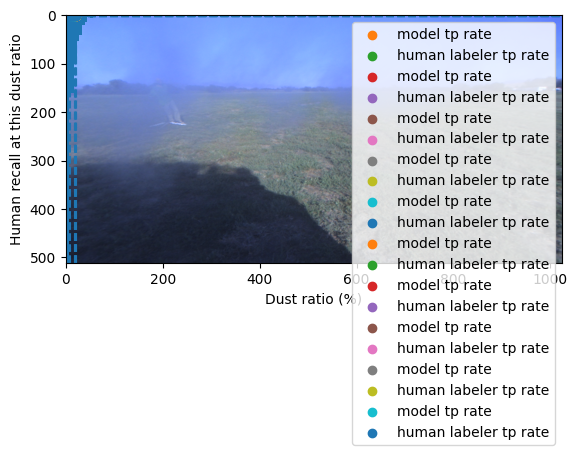

DUSTINESS: 0.0


In [28]:
from dl.utils.io_utils import normalize_image
%matplotlib inline 
df_neg = df[df['predicted_stop'] == False]
def plot(ind):
    data = np.load(data_path + 'processed/images/' + df_neg.iloc[ind]['id'] + '/stereo_output.npz')
    left = normalize_image(data['left'], True)
    plt.imshow(left)
    plt.show()
    print(f"DUSTINESS: {df_neg.iloc[ind]['pred_dust_ratio']}")
plot(4)

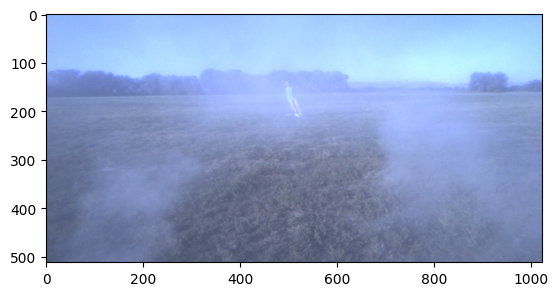

DUSTINESS: 5.9301076


In [29]:
plot(29)

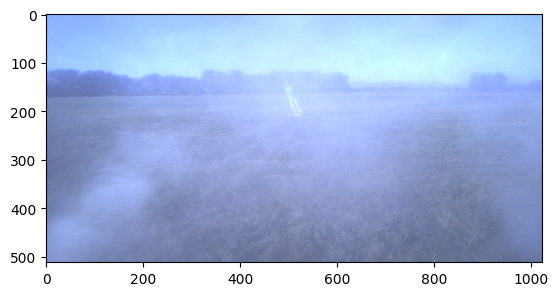

DUSTINESS: 6.914316


In [30]:
plot(37)

In [11]:
%matplotlib inline
plt.scatter(df['pred_dust_ratio'], df['predicted_stop'], s=.5)

In [12]:
plt.hist(df['pred_dust_ratio'])

(array([889., 164., 161.,  89.,  54.,  41.,  21.,  13.,   4.,   5.]),
 array([ 0.      ,  5.493918, 10.987836, 16.481754, 21.975672, 27.46959 ,
        32.963508, 38.457426, 43.951344, 49.445262, 54.93918 ]),
 <BarContainer object of 10 artists>)

# Dust threshold such that, for all images with dust below the threshold
TP / (TP + FN) >= .9

In [13]:
# Li method
# TP + FN = len(df)
FN = TP = 0
df = df.sort_values('pred_dust_ratio')
for i in range(len(df)):
    row = df.iloc[i]
    if row['predicted_stop'] == False:
        FN += 1
    else:
        TP += 1
    x = TP / (TP + FN)
    if abs(x - .9) < .002:
        print(row['pred_dust_ratio']) # ~20

20.382692
20.384338
20.446754
20.502308
20.558844
20.780561
20.840952


In [14]:
import scipy

In [41]:
df.columns

Index(['Unnamed: 0', 'id', 'camera_location_x', 'operation_time_x',
       'num_classes', 'iq_status', 'dust_percent', 'error', 'predicted_stop',
       'label_stop', 'predicted_human', 'label_human', 'predicted_vehicle',
       'label_vehicle', 'stop_nostop_metrics', 'are_stop_objects_filtered',
       'stricter_stop_nostop_metrics', 'product_metrics_safety',
       'product_metrics_nodamage', 'product_metrics_productivity',
       'pixseg_metrics_precision', 'pixseg_metrics_recall',
       'pixseg_metrics_f_score', 'predicted_grid_details',
       'label_grid_details', 'stop_in_object_locator', 'iq_stop',
       'filter_intermediate_output', 'camera_location_y', 'operation_time_y',
       'state', 'additional_state', 'instance_states',
       'instance_additional_states', 'num_instances', 'min_pixels_threshold',
       'gt_dust_label', 'pred_dust_ratio'],
      dtype='object')

In [43]:
# plt.show(df['collected_on'], df['pred_dust_ratio'])

KeyError: 'collected_on'

Recommended dust ratio: 4.1


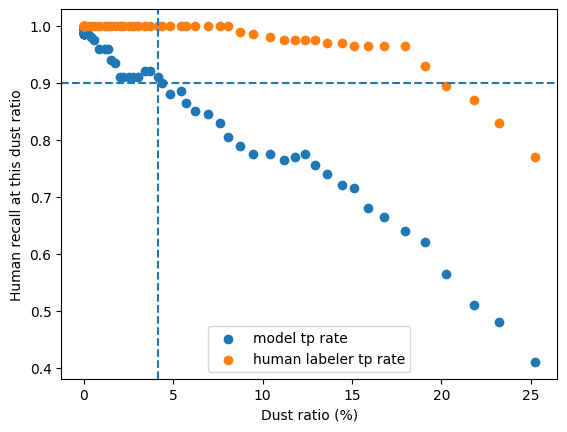

In [40]:
# Alex method
# TP + FN = len(df)
df = df.sort_values('pred_dust_ratio')
interval_size = 200
interval_step = 20
max_valid_ratio = 0
dust_ratio = []
tp_rate = []
human_tp_rate = []
for i in range(0, len(df) - interval_size, interval_step):
    interval = df.iloc[i:i+interval_size]
    TP = interval['predicted_stop'].sum()
    LABEL_P = interval['label_stop'].sum()
    FN = LABEL_P - TP
    r = interval.iloc[interval_size  // 2]['pred_dust_ratio']
    dust_ratio.append(r)
    tp_rate.append(TP / interval_size)
    human_tp_rate.append(interval['label_stop'].sum() / interval_size)
    # how confident are we that it will work on 90% of humans or more at this dust level?
    confidence = scipy.stats.binomtest(TP, LABEL_P, .9, 'less').pvalue
    # if confidence > .9:
    #     max_valid_ratio = r
    # Just check directly
    if TP / LABEL_P > .9:
        max_valid_ratio = r
%matplotlib inline 
plt.scatter(dust_ratio, tp_rate, label='model tp rate')
plt.scatter(dust_ratio, human_tp_rate, label='human labeler tp rate')
plt.axhline(.9,  linestyle='--')
plt.axvline(max_valid_ratio, linestyle='--')
plt.xlabel("Dust ratio (%)")
plt.ylabel("Human recall at this dust ratio")
plt.legend()
print(f"Recommended dust ratio: {max_valid_ratio:.1f}")

In [33]:
# Carmine method
for fn_level in [.05, .1, .2, .3]:
    row = df_neg.sort_values('pred_dust_ratio').iloc[int(fn_level * len(df_neg))]
    print(row['Unnamed: 0'])
    print(f"{100 * fn_level}%: {row.pred_dust_ratio}")

1273
5.0%: 2.0085948
891
10.0%: 3.2335196
8
20.0%: 7.97915
387
30.0%: 11.939393


In [34]:
df_neg['pred_dust_ratio']

605      0.000000
348      0.000000
403      0.000000
245      0.000000
829      0.000000
          ...    
1323    49.942127
794     50.676130
5       50.991880
355     51.332596
1268    54.939180
Name: pred_dust_ratio, Length: 228, dtype: float64

In [35]:
sum(df['human_state'] == 'true_positive')

KeyError: 'human_state'